In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Test Harness Demo

## Some Context   
    
In the Protein Design challenge problem, one of the goals is to be able to predict experimental protein stability from computational features (often derived from or generated by Rosetta software). Protein stability is quantified through a **stability score** that the domain experts have created. 

Over the course of this challenge problem, some methods have been created to make stability scores more accurate, and this is why you see four stability score columns in the data. The latest/best version that should be used is `stabilityscore_cnn_calibrated`.

Proteins with stability scores greater than 1 are considered **stable**, while proteins with stability scores less than or equal to 1 are considered **unstable**. Thus there are two prediction tasks that are possible:
1. Regression Task: prediction of stability score
2. Classification Task: predicting if a protein is "stable" or "unstable"


## Import, Inspect, and Preprocess Data

#### Imports and Settings

In [2]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from harness.test_harness_class import TestHarness
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.random_forest_regression import random_forest_regression
from harness.th_model_instances.hamed_models.rocklin_models import rocklins_logistic_classifier

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### Read in the Data (Rocklin Dataset) and see what it looks like

In [3]:
protein_data = pd.read_csv('rocklin_dataset_simplified.csv', comment='#', low_memory=False)
protein_data.head()

,dataset,name,topology,sequence,dssp,description,assay_library,chip_name,stabilityscore,stabilityscore_calibrated,stabilityscore_cnn,stabilityscore_cnn_calibrated,AlaCount,T1_absq,T1_netq,Tend_absq,Tend_netq,Tminus1_absq,Tminus1_netq,abego_res_profile,abego_res_profile_penalty,avg_all_frags,avg_best_frag,bb,buns_bb_heavy,buns_nonheavy,buns_sc_heavy,buried_minus_exposed,buried_np,buried_np_AFILMVWY,buried_np_AFILMVWY_per_res,buried_np_per_res,buried_over_exposed,chymo_cut_sites,chymo_with_LM_cut_sites,contact_all,contact_core_SASA,contact_core_SCN,contig_not_hp_avg,contig_not_hp_avg_norm,contig_not_hp_internal_max,contig_not_hp_max,degree,dslf_fa13,entropy,exposed_hydrophobics,exposed_np_AFILMVWY,exposed_polars,exposed_total,fa_atr,fa_atr_per_res,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,fa_intra_rep_xover4,fa_intra_sol_xover4,fa_rep,fa_rep_per_res,fa_sol,frac_helix,frac_loop,frac_sheet,fxn_exposed_is_np,hbond_bb_sc,hbond_lr_bb,hbond_lr_bb_per_sheet,hbond_sc,hbond_sr_bb,hbond_sr_bb_per_helix,helix_sc,holes,hphob_sc_contacts,hphob_sc_degree,hxl_tors,hydrophobicity,largest_hphob_cluster,lk_ball,lk_ball_bridge,lk_ball_bridge_uncpl,lk_ball_iso,loop_sc,mismatch_probability,n_charged,n_hphob_clusters,n_hydrophobic,n_hydrophobic_noA,n_polar_core,n_res,nearest_chymo_cut_to_Cterm,nearest_chymo_cut_to_Nterm,nearest_chymo_cut_to_term,nearest_tryp_cut_to_Cterm,nearest_tryp_cut_to_Nterm,nearest_tryp_cut_to_term,net_atr_net_sol_per_res,net_atr_per_res,net_sol_per_res,netcharge,nres,nres_helix,nres_loop,nres_sheet,omega,one_core_each,p_aa_pp,pack,percent_core_SASA,percent_core_SCN,pro_close,rama_prepro,ref,res_count_core_SASA,res_count_core_SCN,score_per_res,ss_contributes_core,ss_sc,sum_best_frags,total_score,tryp_cut_sites,two_core_each,worst6frags,worstfrag
0,Rocklin,HEEH_rd2_0365,HEEH,PQEAEDRARKIKKKNLTTVTIGNYELRYTNPEELARAAKKLLI,LHHHHHHHHHHHHLLLLEEEELLEEEELLLHHHHHHHHHHHHL,data/Rocklin_2017_Science/HEEH_rd2_0365,2.0,NaN,-0.08,-0.08,-0.192347,-0.192347,5.0,3.0,-3.0,6.0,6.0,3.0,3.0,0.266,-0.039,1.291,0.286,-0.136,0.0,0.0,0.0,3537.971,5251.985,2109.095,49.049,122.139,3.064,2,4.5,120.0,120.0,120.0,3.556,0.992,5,10,9.605,0.0,0.0,1714.015,417.905,1719.448,3433.463,-225.818,-5.252,2.330,33.529,39.321,-75.347,-14.851,-6.713,13.402,10.412,51.974,1.209,178.431,0.558,0.256,0.186,0.499,-1.279,-5.867,-0.733,-9.983,-26.451,-1.102,0.764,0.317,12,1.091,14.410,651.0,10,108.047,0.142,0.538,252.770,0.790,0.178,16.0,2,16,11,0.0,43,16,24,16,4,7,4,-1.646,-4.043,2.397,4.0,43.0,24,11,8,2.898,1.0,-12.700,0.636,0.116,0.186,0.53,-10.754,-24.808,5.0,8.0,-2.374,1.0,0.773,10.027,-102.092,10,0.5,3.607,0.831
1,Rocklin,EEHEE_rd2_0259,EEHEE,TTLEVNGEKYTFTSTTEAQEFAKKFGATTIEVRGTTVRVTR,LEEEELLEEEELLLHHHHHHHHHHHLLLEEEEELLEEEEEL,data/Rocklin_2017_Science/EEHEE_rd2_0259,2.0,NaN,-0.05,-0.05,-0.334317,-0.334317,3.0,1.0,-1.0,3.0,3.0,2.0,2.0,0.303,-0.043,1.742,0.291,-0.474,2.0,2.0,0.0,3363.633,4849.817,1902.121,46.393,118.288,3.263,4,4.5,123.0,123.0,123.0,2.818,0.756,8,8,9.585,0.0,0.0,1486.183,230.879,1454.321,2940.505,-196.277,-4.787,1.607,23.157,36.095,-82.119,-12.672,-8.046,10.204,7.882,40.112,0.978,143.187,0.268,0.293,0.439,0.505,-2.512,-19.430,-1.079,-7.067,-15.573,-1.416,0.744,1.791,14,1.400,49.204,820.0,10,97.114,0.530,2.231,218.320,0.744,0.270,11.0,1,13,10,1.0,41,17,10,10,1,9,1,-2.319,-3.809,1.489,1.0,41.0,11,12,18,5.245,0.6,-16.972,0.631,0.098,0.146,0.00,-1.221,-14.858,4.0,6.0,-2.115,1.0,0.744,9.606,-86.716,6,0.4,3.131,0.647
2,Rocklin,EEHEE_rd1_0176,EEHEE,PRVRSNGQTYQATSREEARKIAKKANGKTVEETNDEFRVKK,LEEEELLEEEELLLHHHHHHHHHHHLLLEEEEELLEEEEEL,data/Rocklin_2017_Science/EEHEE_rd1_0176,1.0,NaN,0.54,0.54,0.563990,0.563990,4.0,3.0,-1.0,5.0,3.0,2.0,2.0,0.272,-0.041,1.886,0.525,-0.424,0.0,0.0,0.0,3324.705,4756.853,1331.209,32.469,116.021,3.321,2,2.0,93.0,93.0,93.0,5.000,0.854,10,10,9.341,0.0,0.0,1432.147,152.791,1770.037,3202.184,-202.289,-4.934,2.444,35.878,43.125,-83.496,-13.249,-11.714,8.537,10.223,45.564,1.111,175.014,0.268,0.293,0.439,0.447,-3.707,-

#### Some Preprocessing and Variable Setting

For the regression task, the column named `stabilityscore_cnn_calibrated` can be used as the column to predict.

For the classification task, a new column called `stabilityscore_cnn_calibrated_2classes` is created in the next coding block. This column just assigns a value of True or False depending on if the `stabilityscore_cnn_calibrated` column is larger than 1.

In [4]:
regression_prediction_col = "stabilityscore_cnn_calibrated"
classification_prediction_col = "stabilityscore_cnn_calibrated_2classes"

protein_data.insert(12, classification_prediction_col, protein_data[regression_prediction_col] > 1)

For this dataset, all the feature columns are after the stabilityscore columns, starting with `AlaCount`.

So we can use that information to obtain all the feature_columns. There should be **113 feature columns**.

In [5]:
feature_columns = protein_data.columns.values.tolist()[13:]
print("Number of Feature Columns: {}".format(len(feature_columns)))

Number of Feature Columns: 113


In [6]:
protein_data.head()

,dataset,name,topology,sequence,dssp,description,assay_library,chip_name,stabilityscore,stabilityscore_calibrated,stabilityscore_cnn,stabilityscore_cnn_calibrated,stabilityscore_cnn_calibrated_2classes,AlaCount,T1_absq,T1_netq,Tend_absq,Tend_netq,Tminus1_absq,Tminus1_netq,abego_res_profile,abego_res_profile_penalty,avg_all_frags,avg_best_frag,bb,buns_bb_heavy,buns_nonheavy,buns_sc_heavy,buried_minus_exposed,buried_np,buried_np_AFILMVWY,buried_np_AFILMVWY_per_res,buried_np_per_res,buried_over_exposed,chymo_cut_sites,chymo_with_LM_cut_sites,contact_all,contact_core_SASA,contact_core_SCN,contig_not_hp_avg,contig_not_hp_avg_norm,contig_not_hp_internal_max,contig_not_hp_max,degree,dslf_fa13,entropy,exposed_hydrophobics,exposed_np_AFILMVWY,exposed_polars,exposed_total,fa_atr,fa_atr_per_res,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,fa_intra_rep_xover4,fa_intra_sol_xover4,fa_rep,fa_rep_per_res,fa_sol,frac_helix,frac_loop,frac_sheet,fxn_exposed_is_np,hbond_bb_sc,hbond_lr_bb,hbond_lr_bb_per_sheet,hbond_sc,hbond_sr_bb,hbond_sr_bb_per_helix,helix_sc,holes,hphob_sc_contacts,hphob_sc_degree,hxl_tors,hydrophobicity,largest_hphob_cluster,lk_ball,lk_ball_bridge,lk_ball_bridge_uncpl,lk_ball_iso,loop_sc,mismatch_probability,n_charged,n_hphob_clusters,n_hydrophobic,n_hydrophobic_noA,n_polar_core,n_res,nearest_chymo_cut_to_Cterm,nearest_chymo_cut_to_Nterm,nearest_chymo_cut_to_term,nearest_tryp_cut_to_Cterm,nearest_tryp_cut_to_Nterm,nearest_tryp_cut_to_term,net_atr_net_sol_per_res,net_atr_per_res,net_sol_per_res,netcharge,nres,nres_helix,nres_loop,nres_sheet,omega,one_core_each,p_aa_pp,pack,percent_core_SASA,percent_core_SCN,pro_close,rama_prepro,ref,res_count_core_SASA,res_count_core_SCN,score_per_res,ss_contributes_core,ss_sc,sum_best_frags,total_score,tryp_cut_sites,two_core_each,worst6frags,worstfrag
0,Rocklin,HEEH_rd2_0365,HEEH,PQEAEDRARKIKKKNLTTVTIGNYELRYTNPEELARAAKKLLI,LHHHHHHHHHHHHLLLLEEEELLEEEELLLHHHHHHHHHHHHL,data/Rocklin_2017_Science/HEEH_rd2_0365,2.0,NaN,-0.08,-0.08,-0.192347,-0.192347,False,5.0,3.0,-3.0,6.0,6.0,3.0,3.0,0.266,-0.039,1.291,0.286,-0.136,0.0,0.0,0.0,3537.971,5251.985,2109.095,49.049,122.139,3.064,2,4.5,120.0,120.0,120.0,3.556,0.992,5,10,9.605,0.0,0.0,1714.015,417.905,1719.448,3433.463,-225.818,-5.252,2.330,33.529,39.321,-75.347,-14.851,-6.713,13.402,10.412,51.974,1.209,178.431,0.558,0.256,0.186,0.499,-1.279,-5.867,-0.733,-9.983,-26.451,-1.102,0.764,0.317,12,1.091,14.410,651.0,10,108.047,0.142,0.538,252.770,0.790,0.178,16.0,2,16,11,0.0,43,16,24,16,4,7,4,-1.646,-4.043,2.397,4.0,43.0,24,11,8,2.898,1.0,-12.700,0.636,0.116,0.186,0.53,-10.754,-24.808,5.0,8.0,-2.374,1.0,0.773,10.027,-102.092,10,0.5,3.607,0.831
1,Rocklin,EEHEE_rd2_0259,EEHEE,TTLEVNGEKYTFTSTTEAQEFAKKFGATTIEVRGTTVRVTR,LEEEELLEEEELLLHHHHHHHHHHHLLLEEEEELLEEEEEL,data/Rocklin_2017_Science/EEHEE_rd2_0259,2.0,NaN,-0.05,-0.05,-0.334317,-0.334317,False,3.0,1.0,-1.0,3.0,3.0,2.0,2.0,0.303,-0.043,1.742,0.291,-0.474,2.0,2.0,0.0,3363.633,4849.817,1902.121,46.393,118.288,3.263,4,4.5,123.0,123.0,123.0,2.818,0.756,8,8,9.585,0.0,0.0,1486.183,230.879,1454.321,2940.505,-196.277,-4.787,1.607,23.157,36.095,-82.119,-12.672,-8.046,10.204,7.882,40.112,0.978,143.187,0.268,0.293,0.439,0.505,-2.512,-19.430,-1.079,-7.067,-15.573,-1.416,0.744,1.791,14,1.400,49.204,820.0,10,97.114,0.530,2.231,218.320,0.744,0.270,11.0,1,13,10,1.0,41,17,10,10,1,9,1,-2.319,-3.809,1.489,1.0,41.0,11,12,18,5.245,0.6,-16.972,0.631,0.098,0.146,0.00,-1.221,-14.858,4.0,6.0,-2.115,1.0,0.744,9.606,-86.716,6,0.4,3.131,0.647
2,Rocklin,EEHEE_rd1_0176,EEHEE,PRVRSNGQTYQATSREEARKIAKKANGKTVEETNDEFRVKK,LEEEELLEEEELLLHHHHHHHHHHHLLLEEEEELLEEEEEL,data/Rocklin_2017_Science/EEHEE_rd1_0176,1.0,NaN,0.54,0.54,0.563990,0.563990,False,4.0,3.0,-1.0,5.0,3.0,2.0,2.0,0.272,-0.041,1.886,0.525,-0.424,0.0,0.0,0.0,3324.705,4756.853,1331.209,32.469,116.021,3.321,2,2.0,93.0,93.0,93.0,5.000,0.854,10,10,9.341,0.0,0.0,1432.147,152.791,1770.037,3202.184,-202.289,-4.934,2.444,35.878,43.125,-83.496,-13.249,-11.714,8.537,10.

## Begin Test Harness Usage

In the next code block, I set the path to the directory in which I want my results to go by setting the `output_location` argument. When the Test Harness runs, it will create a `test_harness_results` folder inside of `output_location` and place all results inside of it. If the `test_harness_results` folder already exists, then previous results/leaderboards will be updated. In this demo, the `output_location` has been set to the current path.

In [7]:
current_path = os.getcwd()
th = TestHarness(output_location=current_path)

print("Test Harness output_location: {}".format(current_path))
print()


Test Harness output_location: /Users/he/PycharmProjects/SD2/test-harness/example_scripts/Data_Sharing_Demo



### Custom Run with Extraction of Important Features

#### Create Training and Testing Splits, Stratified on Topology
**80%** of the Data is randomly selected for training

The remaining **20%** of Data is used for testing

In [8]:
train_df, test_df = train_test_split(protein_data, test_size=0.2, random_state=5, stratify=protein_data['topology'])
print("Shape of train_df: {}".format(train_df.shape))
print("Shape of test_df: {}".format(test_df.shape))

Shape of train_df: (12927, 126)
Shape of test_df: (3232, 126)


#### Custom Runs have the following arguments:
- `function_that_returns_TH_model`: pass in your Test Harness model here. In this case it is a Random Forest model.
- `dict_of_function_parameters`: dictionary for Test Harness model hyperparameters. Not applicable for this Demo.
- `training_data`: training Dataframe
- `testing_data`: testing Dataframe
- `data_and_split_description`: string description to help user keep track of runs
- `cols_to_predict`: one or more columns in the data to predict values for (i.e. the label column)
- `feature_cols_to_use`: features to use as input to the model
- `index_cols`: columns that uniquely define your samples when combined. These columns are the only ones output in the `training_data.csv` and `testing_data.csv` files at the end of your run to save disk space.
- `normalize`: will scale your data using sklearn's `StandardScalar` before training and testing. Other options will be added soon.
- `feature_cols_to_normalize`: a list of columns in the Data that you want to normalize (if `normalize` is not False). Usually the same as `feature_cols_to_use`.
- `feature_extraction`: different options for extracting features that are important to the model's performance.
- `predict_untested_data`: pass-in a Dataframe if you want to predict values for data that has no labels.

In [10]:
th.run_custom(function_that_returns_TH_model=random_forest_regression, dict_of_function_parameters={}, 
              training_data=train_df, testing_data=test_df,
              data_and_split_description="Demo Run on Rocklin dataset",
              cols_to_predict=regression_prediction_col,
              feature_cols_to_use=feature_columns,
              index_cols=["dataset", "name"],
              normalize=True, feature_cols_to_normalize=feature_columns,
              feature_extraction="rfpimp_permutation", predict_untested_data=False)

----------------------------------------------------------------------------------------------------
Starting run at time 10:39:50
Normalizing training and testing splits...
Starting Regression training...
Training time was: 37.89 seconds
Testing time was: 0.33 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 24.17 seconds

          Run ID        Date      Time                Model Name Model Author  R-Squared   RMSE Samples In Train Samples In Test                                                                                                                     Model Description               Column Predicted Num Features Used   Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  QPL8GbQMZkLO9  2019-07-30  10:39:50  random_forest_regression  Hamed        0.599      0.456  12927            3232            Random Forest: bootstrap=False, min_samples_leaf=1, n_estimators=689, 

#### Performance Results of Custom Run:

In [12]:
test_harness_results_path = os.path.join(current_path, "test_harness_results")

custom_regression_leaderboard = pd.read_html(os.path.join(test_harness_results_path, 
                                                          "custom_regression_leaderboard.html"))[0]

custom_regression_leaderboard

,Run ID,Date,Time,Model Name,Model Author,R-Squared,RMSE,Samples In Train,Samples In Test,Model Description,Column Predicted,Num Features Used,Data and Split Description,Normalized,Num Features Normalized,Feature Extraction,Was Untested Data Predicted
0,QPL8GbQMZkLO9,2019-07-30,10:39:50,random_forest_regression,Hamed,0.599,0.456,12927,3232,"Random Forest: bootstrap=False, min_samples_leaf=1, n_estimators=689, min_samples_split=2, max_features=0.2, max_depth=86, n_jobs=-1",stabilityscore_cnn_calibrated,113,Demo Run on Rocklin dataset,True,113,rfpimp_permutation,False
1,EmWMqQVVXpBRJ,2019-07-30,10:34:58,random_forest_regression,Hamed,0.598,0.456,12927,3232,"Random Forest: bootstrap=False, min_samples_leaf=1, n_estimators=689, min_samples_split=2, max_features=0.2, max_depth=86, n_jobs=-1",stabilityscore_cnn_calibrated,113,Demo Run on Rocklin dataset,True,113,rfpimp_permutation,False


#### Plotting Important Features of Custom Run:

In [13]:
run_id = custom_regression_leaderboard.iloc[0]["Run ID"]
run_id

'QPL8GbQMZkLO9'

In [14]:
feature_importance_df = pd.read_csv(os.path.join(test_harness_results_path, 
                                                 "runs/run_{}/feature_importances.csv".format(run_id)))
feature_importance_df.head()

,Feature,Importance
0,score_per_res,0.025290
1,net_atr_net_sol_per_res,0.019135
2,total_score,0.012374
3,sum_best_frags,0.011073
4,avg_all_frags,0.009354


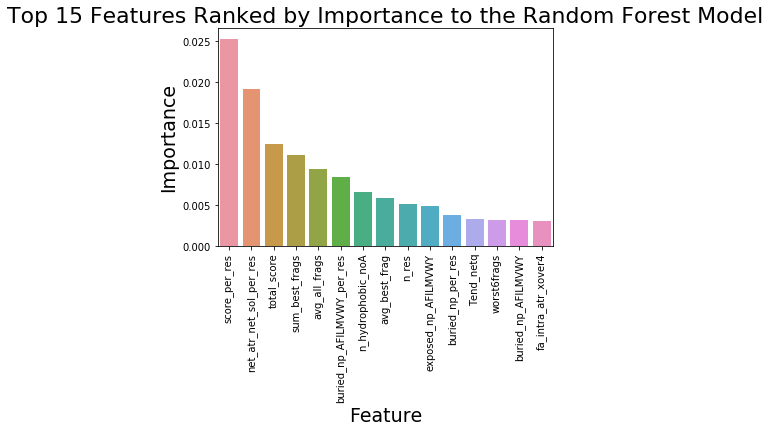

In [15]:
%matplotlib inline
ax = sns.barplot(x="Feature", y="Importance", data=feature_importance_df[:15])
ax.set_title("Top 15 Features Ranked by Importance to the Random Forest Model", fontsize=22)
ax.set_xlabel("Feature", fontsize=19)
ax.set_ylabel("Importance", fontsize=19)
plt.xticks(rotation=90)
plt.show()

### Leave-One-Out Runs

The leave-one-out method will create splits of data based on the passed-in grouping. The model will then be run on each created split.

#### Leave-One-Out Runs have the following arguments:
- `function_that_returns_TH_model`: pass in your Test Harness model here.
- `dict_of_function_parameters`: dictionary for Test Harness model hyperparameters. Not applicable for this Demo.
- `data`: Dataframe of all the data. You do not need separate training and testing Dataframes because the Leave-One-Out Method creates all the splits for you based on the `grouping` you pass in.
- `data_description`: string description to help user keep track of runs
- `grouping`: list of column names to create groupings and train/test splits from.
- `grouping_description`: string description to help user keep track of runs
- `cols_to_predict`: one or more columns in the data to predict values for (i.e. the label column)
- `feature_cols_to_use`: features to use as input to the model
- `index_cols`: columns that uniquely define your samples when combined. These columns are the only ones output in the `training_data.csv` and `testing_data.csv` files at the end of your runs to save disk space.
- `normalize`: will scale your data using sklearn's `StandardScalar` before training and testing. Other options will be added soon.
- `feature_cols_to_normalize`: a list of columns in the Data that you want to normalize (if `normalize` is not False). Usually the same as `feature_cols_to_use`.
- `feature_extraction`: different options for extracting features that are important to the model's performance."

In [16]:
# Model = Baseline Logistic Classifier:
th.run_leave_one_out(function_that_returns_TH_model=rocklins_logistic_classifier, dict_of_function_parameters={}, 
                     data=protein_data, data_description="Rocklin dataset",
                     grouping=["topology"], grouping_description="topology", 
                     cols_to_predict=classification_prediction_col,
                     feature_cols_to_use=feature_columns, 
                     index_cols=["dataset", "name"], 
                     normalize=True, feature_cols_to_normalize=feature_columns, 
                     feature_extraction=False)

Creating test split based on group_index 0, defined by: {'topology': ['EEHEE'], 'group_index': [0]}
Number of samples in train split: (10912, 127)
Number of samples in test split: (5247, 127)
----------------------------------------------------------------------------------------------------
Starting run at time 10:44:57
Normalizing training and testing splits...
Starting Classification training...


/Users/he/anaconda3/envs/test-harness/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/he/anaconda3/envs/test-harness/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Training time was: 0.74 seconds
Testing time was: 0.02 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                         Model Description                        Column Predicted Num Features Used Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted Leave-One-Out ID                                   Test Group
0  EzrElLWV8dAlJ  2019-07-30  10:44:57  rocklins_logistic_classifier  Hamed        2           0.895     0.526              0.891      0.553              0.101     0.912      0.054   10912            5247            Rocklin Logistic: penalty='l1' and C=0.1  stabilityscore_cnn_calibrated_2classes  113               Rocklin dataset            True       113                     False              False                       5rp1wAM9yrgk5    {'topolo

/Users/he/anaconda3/envs/test-harness/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/he/anaconda3/envs/test-harness/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Training time was: 1.61 seconds
Testing time was: 0.01 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                         Model Description                        Column Predicted Num Features Used Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted Leave-One-Out ID                                  Test Group
0  6lOwJoXAqpVe3  2019-07-30  10:44:58  rocklins_logistic_classifier  Hamed        2           0.805     0.501              0.883      0.653              0.003     1.0        0.001   12702            3457            Rocklin Logistic: penalty='l1' and C=0.1  stabilityscore_cnn_calibrated_2classes  113               Rocklin dataset            True       113                     False              False                       5rp1wAM9yrgk5    {'topolog

/Users/he/anaconda3/envs/test-harness/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/he/anaconda3/envs/test-harness/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Training time was: 0.66 seconds
Testing time was: 0.01 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                         Model Description                        Column Predicted Num Features Used Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted Leave-One-Out ID                                  Test Group
0  5rQjyV6kkLzEb  2019-07-30  10:45:00  rocklins_logistic_classifier  Hamed        2           0.967     0.562              0.718      0.087              0.162     0.198      0.137   11173            4986            Rocklin Logistic: penalty='l1' and C=0.1  stabilityscore_cnn_calibrated_2classes  113               Rocklin dataset            True       113                     False              False                       5rp1wAM9yrgk5    {'topolog

/Users/he/anaconda3/envs/test-harness/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/he/anaconda3/envs/test-harness/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Training time was: 1.11 seconds
Testing time was: 0.01 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                         Model Description                        Column Predicted Num Features Used Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted Leave-One-Out ID                                 Test Group
0  6lXR9EXgNYYOG  2019-07-30  10:45:01  rocklins_logistic_classifier  Hamed        2           0.485     0.527              0.846      0.844              0.113     0.92       0.06    13690            2469            Rocklin Logistic: penalty='l1' and C=0.1  stabilityscore_cnn_calibrated_2classes  113               Rocklin dataset            True       113                     False              False                       5rp1wAM9yrgk5    {'topology

In [17]:
# Model = Random Forest Regressor:
th.run_leave_one_out(function_that_returns_TH_model=random_forest_classification, dict_of_function_parameters={}, 
                     data=protein_data, data_description="Rocklin dataset",
                     grouping=["topology"], grouping_description="topology", 
                     cols_to_predict=classification_prediction_col,
                     feature_cols_to_use=feature_columns, 
                     index_cols=["dataset", "name"], 
                     normalize=True, feature_cols_to_normalize=feature_columns, 
                     feature_extraction=False)

Creating test split based on group_index 0, defined by: {'topology': ['EEHEE'], 'group_index': [0]}
Number of samples in train split: (10912, 127)
Number of samples in test split: (5247, 127)
----------------------------------------------------------------------------------------------------
Starting run at time 10:45:06
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.63 seconds
Testing time was: 0.44 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description                        Column Predicted Num Features Used Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted Leave-One-Out ID                                 

/Users/he/anaconda3/envs/test-harness/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/he/anaconda3/envs/test-harness/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Performance Results of Leave-One-Out Runs:

In [18]:
loo_df = pd.read_html("test_harness_results/loo_detailed_classification_leaderboard.html")[0]

In [19]:
# Parse out the information we're interested in plotting. In this case we are interested in the topology.
import ast
loo_df["tested_topology"] = loo_df["Test Group"].apply(lambda x: ast.literal_eval(x)["topology"][0])

In [20]:
loo_df

,Run ID,Date,Time,Model Name,Model Author,Num Classes,Accuracy,Balanced Accuracy,AUC Score,Average Precision,F1 Score,Precision,Recall,Samples In Train,Samples In Test,Model Description,Column Predicted,Num Features Used,Data and Split Description,Normalized,Num Features Normalized,Feature Extraction,Was Untested Data Predicted,Leave-One-Out ID,Test Group,tested_topology
0,6lXR9EXgNYYOG,2019-07-30,10:45:01,rocklins_logistic_classifier,Hamed,2,0.485,0.527,0.846,0.844,0.113,0.920,0.060,13690,2469,Rocklin Logistic: penalty='l1' and C=0.1,stabilityscore_cnn_calibrated_2classes,113,Rocklin dataset,True,113,False,False,5rp1wAM9yrgk5,"{'topology': ['HHH'], 'group_index': [3]}",HHH
1,ap3q2A1jzpA7V,2019-07-30,10:45:19,random_forest_classification,Hamed,2,0.455,0.500,0.798,0.781,0.000,0.000,0.000,13690,2469,"Random Forest: n_estimators=361, max_features=auto, criterion=entropy, min_samples_leaf=13, n_jobs=-1",stabilityscore_cnn_calibrated_2classes,113,Rocklin dataset,True,113,False,False,Q933WJdmEZN2o,"{'topology': ['HHH'], 'group_index': [3]}",HHH
2,6lOwJoXAqpVe3,2019-07-30,10:44:58,rocklins_logistic_classifier,Hamed,2,0.805,0.501,0.883,0.653,0.003,1.000,0.001,12702,3457,Rocklin Logistic: penalty='l1' and C=0.1,stabilityscore_cnn_calibrated_2classes,113,Rocklin dataset,True,113,False,False,5rp1wAM9yrgk5,"{'topology': ['EHEE'], 'group_index': [1]}",EHEE
3,6lBLkVq5PQlJO,2019-07-30,10:45:10,random_forest_classification,Hamed,2,0.809,0.512,0.859,0.601,0.049,0.895,0.025,12702,3457,"Random Forest: n_estimators=361, max_features=auto, criterion=entropy, min_samples_leaf=13, n_jobs=-1",stabilityscore_cnn_calibrated_2classes,113,Rocklin dataset,True,113,False,False,Q933WJdmEZN2o,"{'topology': ['EHEE'], 'group_index': [1]}",EHEE
4,EzxmLybD6NMX8,2019-07-30,10:45:06,random_forest_classification,Hamed,2,0.875,0.835,0.924,0.597,0.579,0.459,0.784,10912,5247,"Random Forest: n_estimators=361, max_features=auto, criterion=entropy, min_samples_leaf=13, n_jobs=-1",stabilityscore_cnn_calibrated_2classes,113,Rocklin dataset,True,113,False,False,Q933WJdmEZN2o,"{'topology': ['EEHEE'], 'group_index': [0]}",EEHEE
5,EzrElLWV8dAlJ,2019-07-30,10:44:57,rocklins_logistic_classifier,Hamed,2,0.895,0.526,0.891,0.553,0.101,0.912,0.054,10912,5247,Rocklin Logistic: penalty='l1' and C=0.1,stabilityscore_cnn_calibrated_2classes,113,Rocklin dataset,True,113,False,False,5rp1wAM9yrgk5,"{'topology': ['EEHEE'], 'group_index': [0]}",EEHEE
6,5rQjyV6kkLzEb,2019-07-30,10:45:00,rocklins_logistic_classifier,Hamed,2,0.967,0.562,0.718,0.087,0.162,0.198,0.137,11173,4986,Rocklin Logistic: penalty='l1' and C=0.1,stabilityscore_cnn_calibrated_2classes,113,Rocklin dataset,True,113,False,False,5rp1wAM9yrgk5,"{'topology': ['HEEH'], 'group_index': [2]}",HEEH
7,OBWWy3z8Y6rLL,2019-07-30,10:45:15,random_forest_classification,Hamed,2,0.952,0.538,0.712,0.055,0.091,0.082,0.103,11173,4986,"Random Forest: n_estimators=361, max_features=auto, criterion=entropy, min_samples_leaf=13, n_jobs=-1",stabilityscore_cnn_calibrated_2classes,113,Rocklin dataset,True,113,False,False,Q933WJdmEZN2o,"{'topology': ['HEEH'], 'group_index': [2]}",HEEH


#### Plotting Performance Results

In [21]:
# This is a function from the Test Harness repo that makes plotting easier
def vis_barplot(data_df, x_colname, y_colname, title, x_label, y_label, color_by_col, hue_order=None, 
                palette="colorblind", legend=True, legend_title=None, legend_location="lower right", 
                legend_dict=None, sort=True, rotate_x_ticks=90):
    sns.set(rc={'figure.figsize': (22, 10)})
    if sort is True:
        data_df.sort_values(by=y_colname, inplace=True, ascending=False)
    ax = sns.barplot(x=x_colname, y=y_colname, hue=color_by_col, data=data_df, palette=palette,
                     hue_order=hue_order)
    ax.set_title(title, fontsize=22)
    ax.set_xlabel(x_label, fontsize=19)
    ax.set_ylabel(y_label, fontsize=19)
    ax.tick_params(labelsize=14)
    if legend is True:
        lgnd = ax.legend(title=legend_title, fontsize=14, loc=legend_location)
        if legend_dict is not None:
            for key, item in legend_dict.items():
                lgnd.get_texts()[key].set_text(item)
        lgnd.get_title().set_fontsize(15)

    plt.xticks(rotation=rotate_x_ticks)
    plt.show()
    plt.gcf().clear()

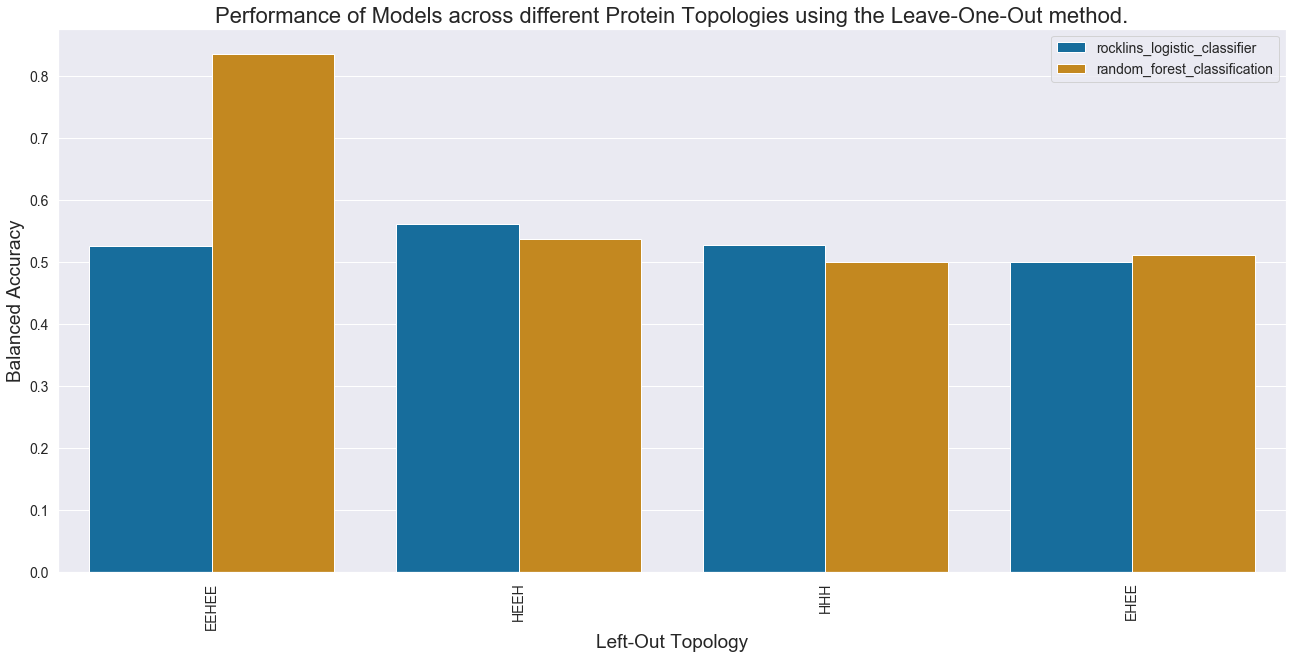

<Figure size 1584x720 with 0 Axes>

In [22]:
vis_barplot(data_df=loo_df,
            x_colname="tested_topology", y_colname="Balanced Accuracy",
            x_label="Left-Out Topology", y_label="Balanced Accuracy",
            title="Performance of Models across different Protein Topologies using the Leave-One-Out method.", 
            color_by_col="Model Name", hue_order=["rocklins_logistic_classifier", "random_forest_classification"], 
            legend_location="upper right")